In [1]:
# ClimatePy

In [2]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import numpy as np
from scipy import stats

In [3]:
# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL Toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create engine
engine = create_engine("sqlite:///hawaii2.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [12]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print("Query Date :", query_date)

Query Date : 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()
for record in data:
    print(record)

('2016-08-23', 0.0)
('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)
('2016-08-28', 0.01)
('2016-08-29', 0.0)
('2016-08-30', 0.0)
('2016-08-31', 0.13)
('2016-09-01', 0.0)
('2016-09-02', 0.0)
('2016-09-03', 0.0)
('2016-09-04', 0.03)
('2016-09-05', None)
('2016-09-06', None)
('2016-09-07', 0.05)
('2016-09-08', 0.0)
('2016-09-09', 0.03)
('2016-09-10', 0.0)
('2016-09-11', 0.05)
('2016-09-12', 0.0)
('2016-09-13', 0.02)
('2016-09-14', 1.32)
('2016-09-15', 0.42)
('2016-09-16', 0.06)
('2016-09-17', 0.05)
('2016-09-18', 0.0)
('2016-09-19', 0.0)
('2016-09-20', 0.0)
('2016-09-21', 0.0)
('2016-09-22', 0.02)
('2016-09-23', 0.0)
('2016-09-24', 0.0)
('2016-09-25', 0.0)
('2016-09-26', 0.06)
('2016-09-27', 0.02)
('2016-09-28', 0.0)
('2016-09-29', 0.0)
('2016-09-30', 0.0)
('2016-10-01', 0.0)
('2016-10-02', 0.0)
('2016-10-03', 0.0)
('2016-10-04', 0.0)
('2016-10-05', 0.0)
('2016-10-06', 0.0)
('2016-10-07', 0.0)
('2016-10-08', 0.0)
('2016-10-09', 0.0)
('2016-10-10', 0.0)
('

('2017-05-21', 0.01)
('2017-05-22', 0.06)
('2017-05-23', 0.06)
('2017-05-24', 0.3)
('2017-05-25', 0.2)
('2017-05-26', 0.0)
('2017-05-27', 0.0)
('2017-05-28', 0.08)
('2017-05-29', 0.4)
('2017-05-30', 1.12)
('2017-05-31', 0.25)
('2017-06-01', 0.0)
('2017-06-02', 0.09)
('2017-06-03', 0.08)
('2017-06-04', 0.13)
('2017-06-05', 0.05)
('2017-06-06', 0.0)
('2017-06-07', 0.0)
('2017-06-08', 0.0)
('2017-06-09', 0.02)
('2017-06-10', 0.62)
('2017-06-11', 0.74)
('2017-06-12', 0.24)
('2017-06-13', 0.24)
('2017-06-14', 0.22)
('2017-06-15', 0.55)
('2017-06-16', 0.06)
('2017-06-17', 0.07)
('2017-06-18', 0.24)
('2017-06-19', 0.08)
('2017-06-20', 0.0)
('2017-06-21', 0.19)
('2017-06-22', 0.06)
('2017-06-23', 0.12)
('2017-06-24', 0.36)
('2017-06-25', 0.02)
('2017-06-26', 0.06)
('2017-06-27', 0.01)
('2017-06-28', 0.0)
('2017-06-29', 0.0)
('2017-06-30', 0.01)
('2017-07-01', 0.08)
('2017-07-02', 0.15)
('2017-07-03', 0.15)
('2017-07-04', 0.08)
('2017-07-05', 0.0)
('2017-07-06', 0.0)
('2017-07-07', 0.18)
('2017

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(data, columns = ["date", "prcp"])
climate_df.set_index("date", inplace=True)

# Sort the dataframe by date
climate_df = climate_df.sort_values(["date"])
climate_df.head(100)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2016-09-07,0.05
2016-09-07,0.11
2016-09-07,0.10


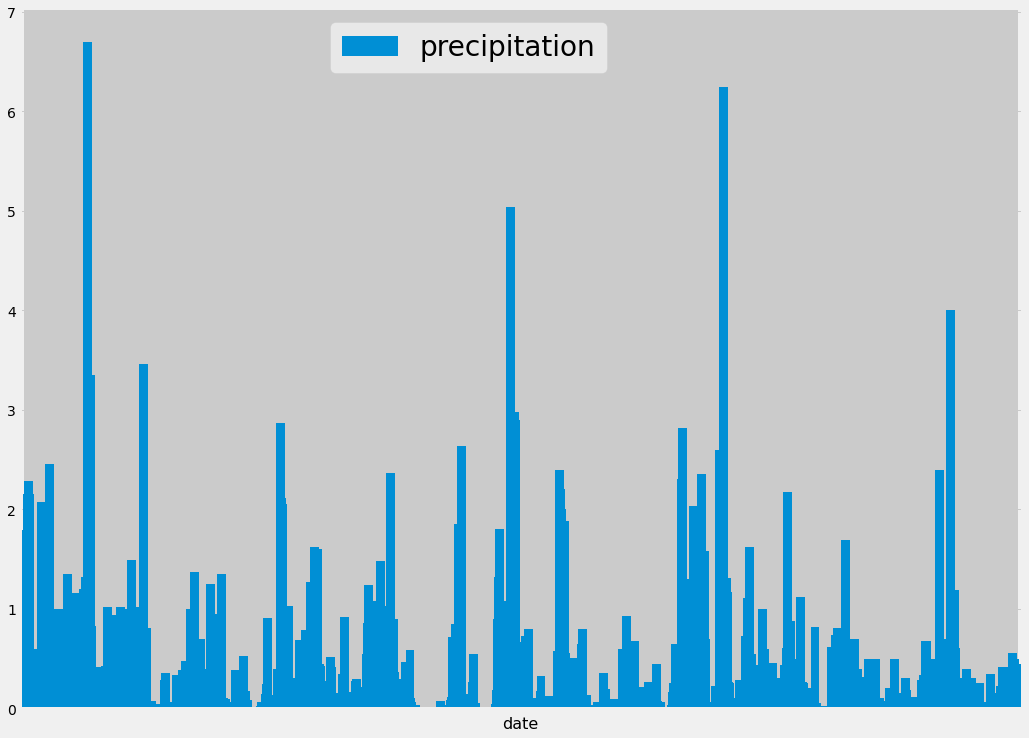

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax= climate_df.plot.bar(figsize=(16,12), width=20)
ax.set_xlabel("date", fontsize=16)
ax.set_xticklabels([])
plt.legend(['precipitation'], fontsize=28)
ax.get_legend().set_bbox_to_anchor((0.6, 1))

plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statistics = climate_df["prcp"].describe()
statistics_df = pd.DataFrame(statistics)
statistics_df.rename(columns = {"prcp": "precipitation"})

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).group_by(Station.station).count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order

session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Grab the most active station
most_active_station=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()
most_active= most_active_station[0]
most_active

'USC00519281'

In [21]:
# Calculate the lowest temperature recorded, highest temperature recorded, 
# and average temperature of the most active station
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data=session.query(Measurement.tobs).filter(Measurement.station==most_active).\
    filter(Measurement.date>=query_date).all()
temp_data

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 

In [23]:
# Create the dataframe
temp_df = pd.DataFrame(temp_data, columns=["tobs"])
temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


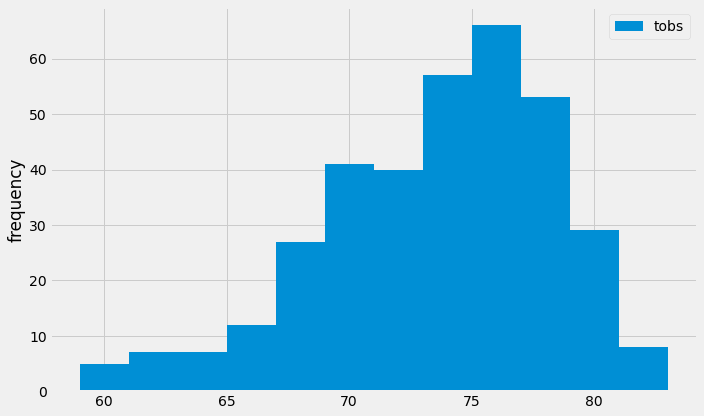

<Figure size 432x288 with 0 Axes>

In [24]:
# Create the plot
plt.figure(figsize=(10,6))
plt.hist(temp_df["tobs"], bins=12)
plt.ylabel("frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Save the plot
# plt.tight_layout()
plt.savefig("frequecy.png")
plt.show()

In [25]:

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function usage example
temps = calc_temps('2017-02-28', '2017-03-05')
temps

[(64.0, 72.02777777777777, 78.0)]

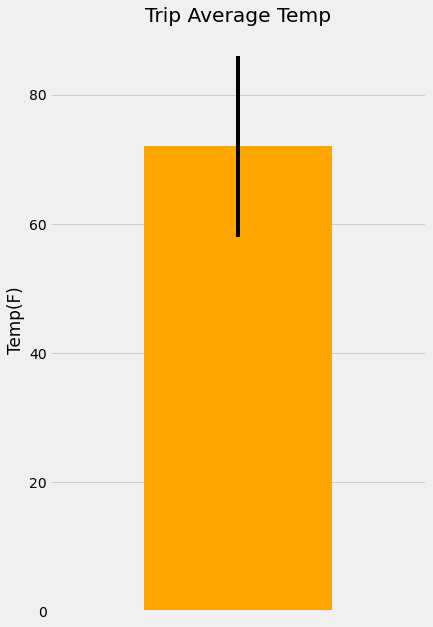

<Figure size 432x288 with 0 Axes>

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create the dataframe
df = pd.DataFrame(temps, columns=["t_min", "t_avg", "t_max"])

# Plot the average temp 
plt.figure(figsize=(6,10))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="orange")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()

# Save the plot
plt.tight_layout()
plt.savefig("avg_temp.png")
plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-02-28'
end_date = '2017-03-05'
sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()
for r in rainfall:
    print(r)

(6, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(6, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(6, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(6, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(5, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(3, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(2, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)


In [29]:
# Hawaii is reputed to enjoy mild weather all year
# Is there a meaningful difference between the temperature in, for example, June and December?

# Identify the average temperature in June at all stations across all available years in the dataset

query_june="06"

june_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_june).all()
june_avg

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [30]:
# Do the same for December temperature.

query_dec="12"


dec_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_dec ).all()
dec_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [31]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant.


# Perform the t-test 
stats.ttest_ind(june_avg, dec_avg, equal_var=False)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start_date = '2017-02-28'
end_date = '2017-03-05'

# Use the start and end date to create a range of dates
trip_dates = ["2018-02-28", "2018-03-01", "2018-03-02", "2018-03-03", "2018-03-04", "2018-03-05"]

# Convert strings to datetime
date_list =[datetime.strptime(date, "%Y-%m-%d") for date in trip_dates]
date_list

# Stip off the year and save a list of %m-%d strings
dates = [date.strftime("%m-%d") for date in date_list]
dates

['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']

In [34]:
dates = ['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']
normals = [daily_normals(date) for date in dates]
normals

[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [35]:
# Flatten the normals list
normal_list = [item for sublist in normals for item in sublist]
normal_list

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normal_list, columns=["tmin","tavg", "tmax"], index=trip_dates)
normals_df.index.name="date"
normals_df

,tmin,tavg,tmax
date,,,
2018-02-28,65.0,70.655172,80.0
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0


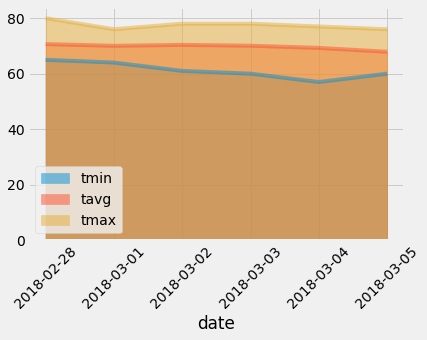

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()